In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display 
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')


/home/sparkm/.local/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2025-03-10 23:24:59.573215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741629299.585694   61632 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741629299.589055   61632 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 23:24:59.603116: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the 

In [2]:
import os
from collections import Counter

paths = []
labels = []
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')   

# Display the number of files for each label
label_distribution = Counter(labels)
print(f"Label distribution: {label_distribution}")

print(f"Total files: {len(paths)}")


Dataset is Loaded
Label distribution: Counter({'fear': 400, 'ps': 400, 'sad': 400, 'angry': 400, 'disgust': 400, 'happy': 400, 'neutral': 400})
Total files: 2800


In [3]:
len(paths) 

2800

In [4]:
paths[:5]

['data/OAF_Fear/OAF_back_fear.wav',
 'data/OAF_Fear/OAF_bar_fear.wav',
 'data/OAF_Fear/OAF_base_fear.wav',
 'data/OAF_Fear/OAF_bath_fear.wav',
 'data/OAF_Fear/OAF_bean_fear.wav']

In [5]:
labels[:5]

['fear', 'fear', 'fear', 'fear', 'fear']

In [6]:
# Display the first 5 elements of paths
paths[:5]

# Display the first 5 elements of labels
labels[:5]

# Create a dataframe
df = pd.DataFrame()
df['audio_paths'] = paths
df['labels'] = labels

# Display the first 5 rows of the dataframe
df.head()


,audio_paths,labels
0,data/OAF_Fear/OAF_back_fear.wav,fear
1,data/OAF_Fear/OAF_bar_fear.wav,fear
2,data/OAF_Fear/OAF_base_fear.wav,fear
3,data/OAF_Fear/OAF_bath_fear.wav,fear
4,data/OAF_Fear/OAF_bean_fear.wav,fear


In [7]:
df['labels'].value_counts()

labels
fear       400
ps         400
sad        400
angry      400
disgust    400
happy      400
neutral    400
Name: count, dtype: int64

<Axes: xlabel='labels', ylabel='count'>

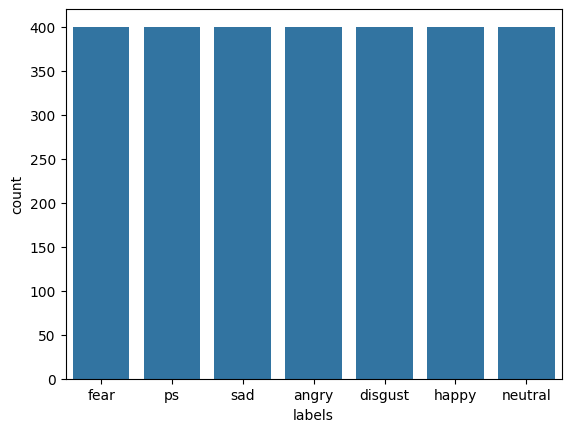

In [8]:
sns.countplot(data=df , x="labels")

In [9]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectrogram(data, sr, emotion):
    xdb = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(xdb))
    plt.figure(figsize=(11, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()




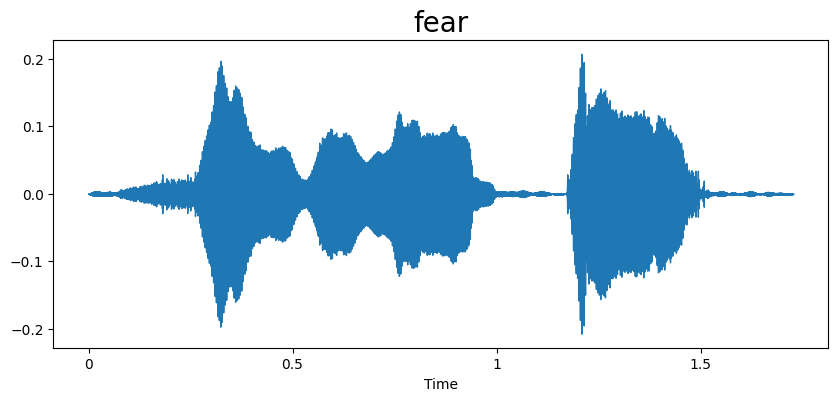

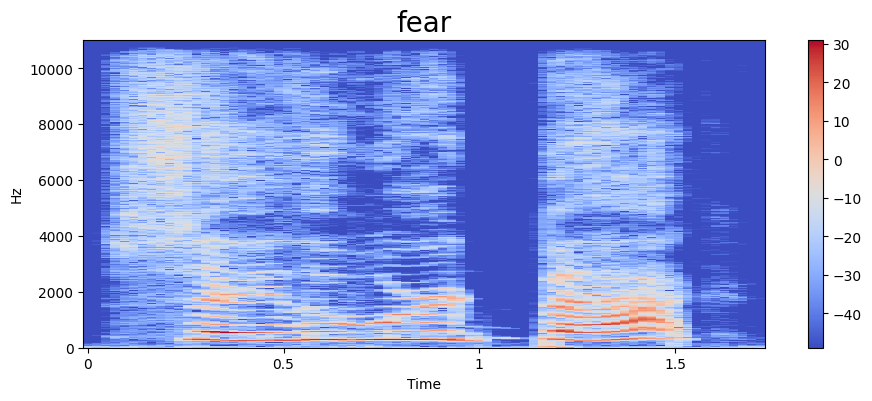

In [10]:
# Example usage
emotion = 'fear'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

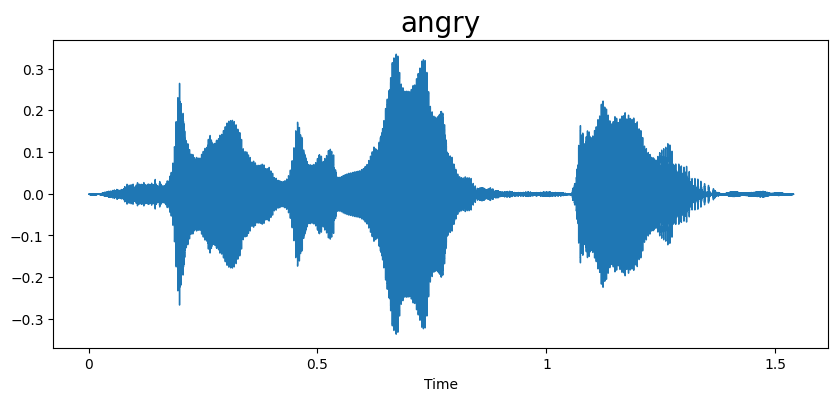

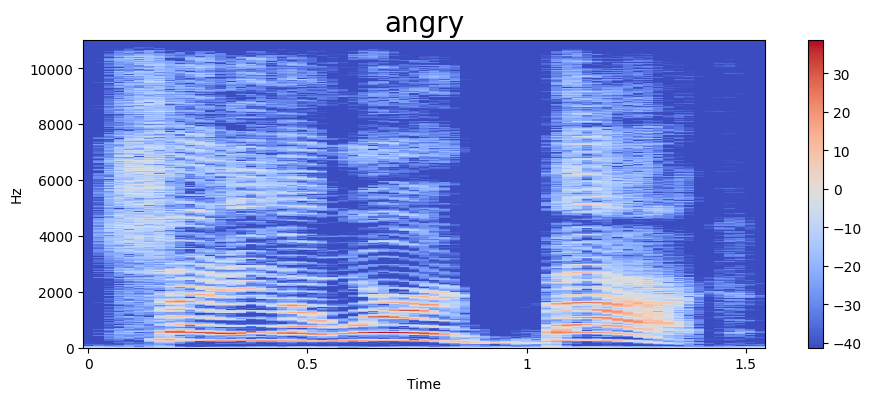

In [11]:
# Example usage
emotion = 'angry'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

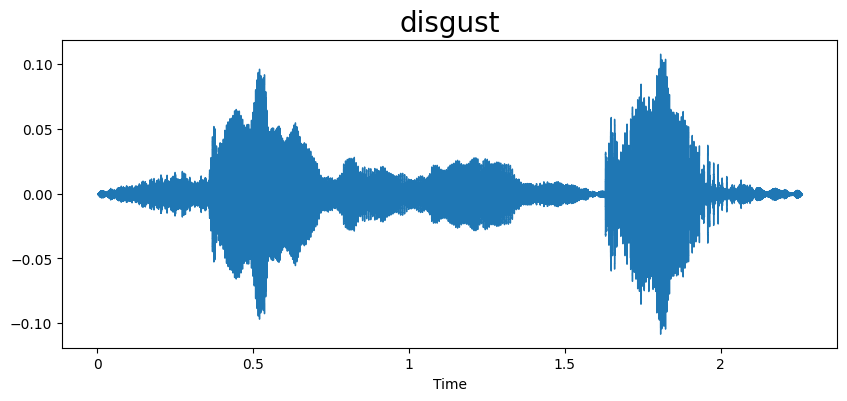

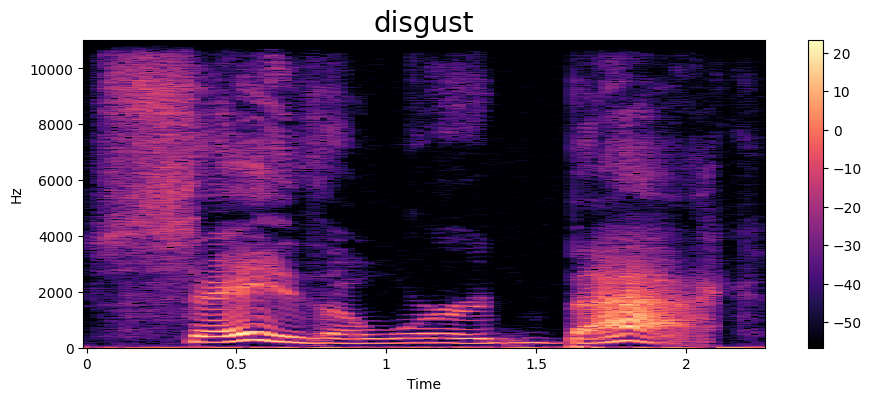

In [12]:
# Example usage
emotion = 'disgust'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

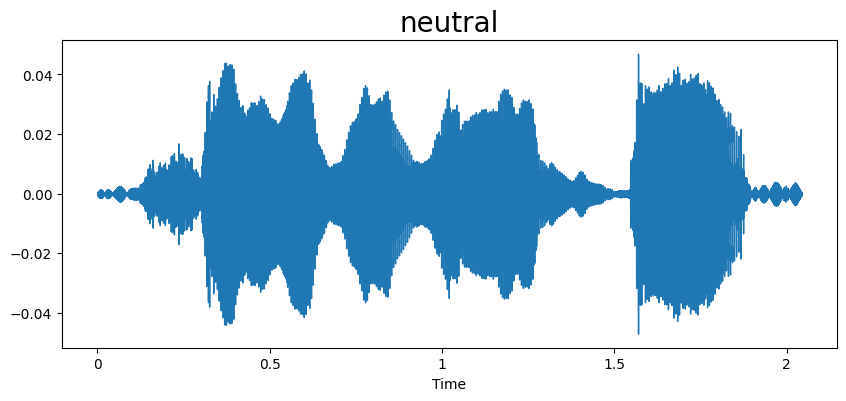

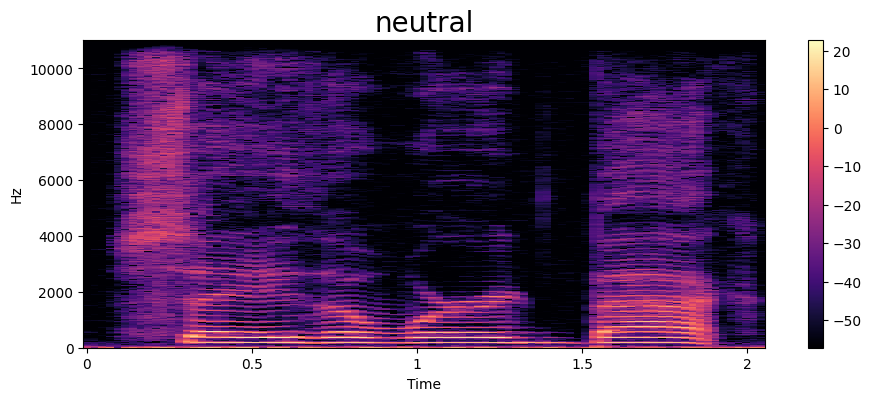

In [13]:
# Example usage
emotion = 'neutral'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

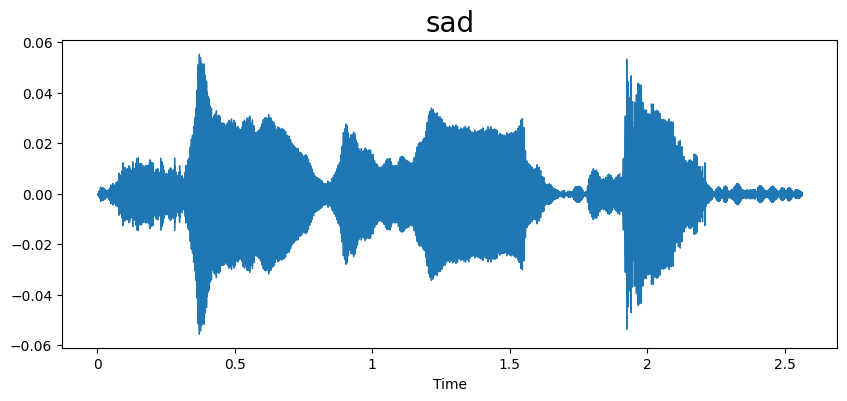

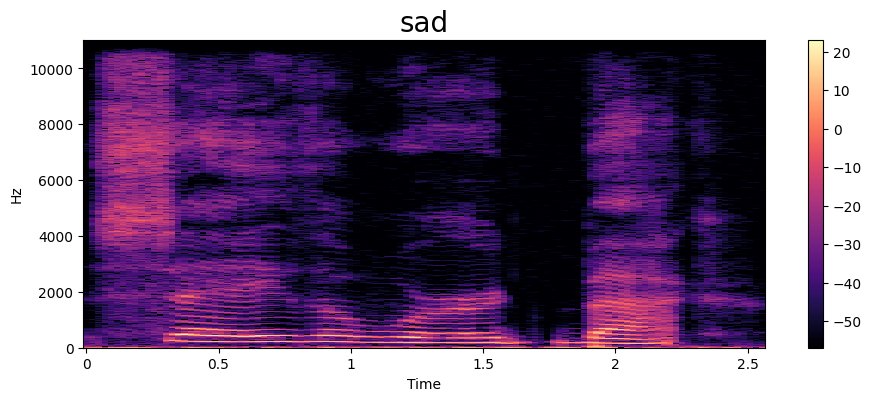

In [14]:
# Example usage
emotion = 'sad'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)



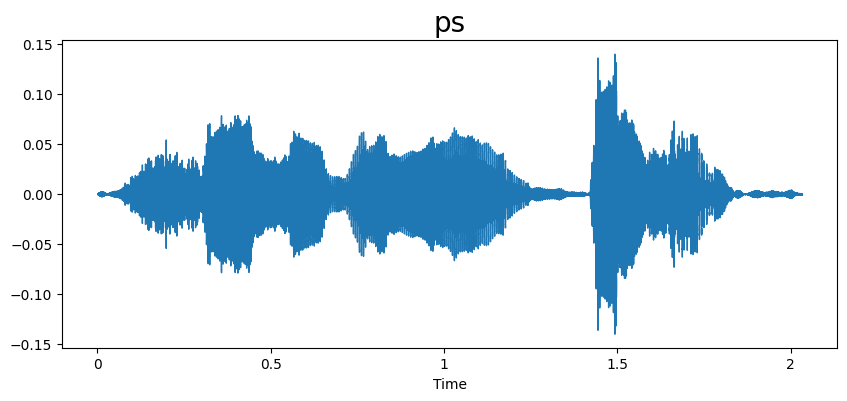

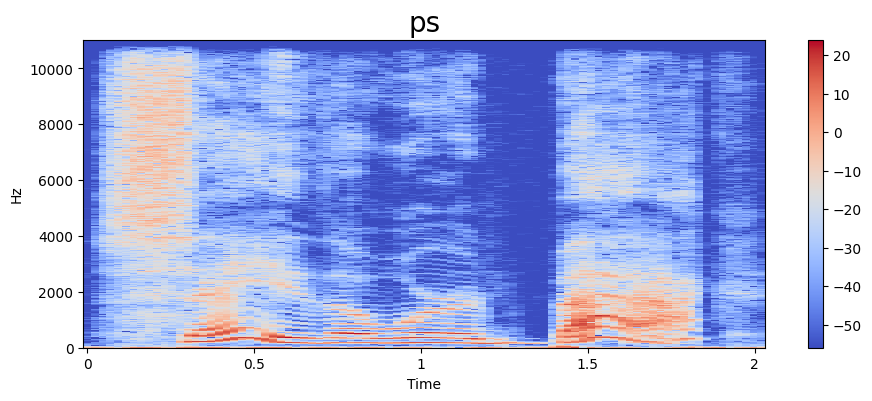

In [15]:
# Example usage
emotion = 'ps'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

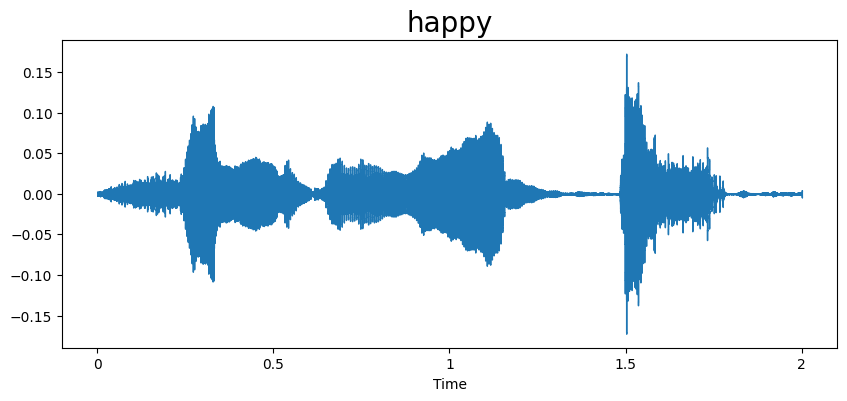

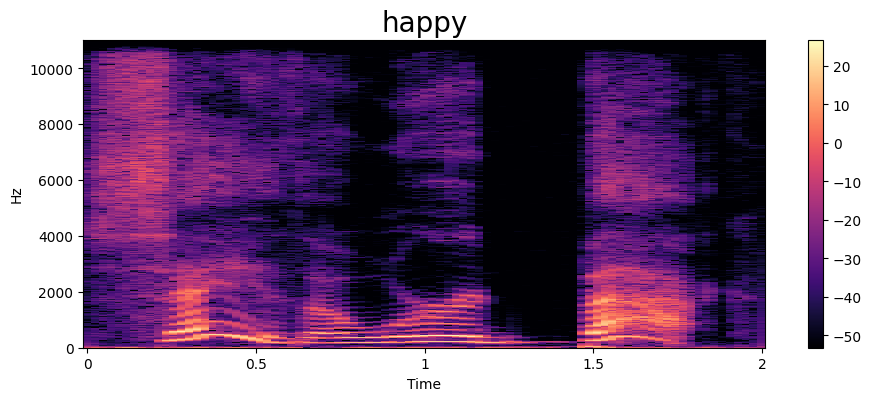

In [16]:
# Example usage
emotion = 'happy'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

# create custom dataset class

In [17]:
# Convert labels to integers
label_map = {label: idx for idx, label in enumerate(df['labels'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df['labels'] = df['labels'].map(label_map)

# Display the first 2 rows of the dataframe
df.head(2)

,audio_paths,labels
0,data/OAF_Fear/OAF_back_fear.wav,0
1,data/OAF_Fear/OAF_bar_fear.wav,0


In [18]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['labels']

        speech , sr =librosa.load(audio_path , sr=16000)
        # Pad or truncate the speech to the required length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

        # Preprocess the audio file
        inputs = self.processor(
            speech, 
            sampling_rate=16000, 
            return_tensors='pt', 
            padding=True, 
            truncation=True, 
            max_length=self.max_length
        )

        # Extract input values
        input_values = inputs.input_values.squeeze()

        # Return a dictionary with input values and labels
        return {
            'input_values': input_values, 
            'labels': torch.tensor(label, dtype=torch.long)
        
        }

In [19]:
# Split the data for train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)



In [20]:
# Initialize the processor and model
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    'facebook/wav2vec2-base', 
    num_labels=7
)


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Load the dataset
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)




In [22]:
# Access the first element in the training dataset
train_dataset[0]

{'input_values': tensor([-0.0061, -0.0116, -0.0102,  ...,  0.0942,  0.0895,  0.0904]),
 'labels': tensor(2)}

In [23]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)




In [24]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[]
)




In [25]:
# Create functions for computing metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids  # Original labels
    preds = np.argmax(pred.predictions, axis=1)  # Model predicted labels
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [26]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Start the training process
trainer.train()


  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 0.7939868569374084, 'eval_accuracy': 0.9571428571428572, 'eval_precision': 0.9634623079385404, 'eval_recall': 0.9571428571428572, 'eval_f1': 0.9580456646495916, 'eval_runtime': 52.951, 'eval_samples_per_second': 10.576, 'eval_steps_per_second': 0.661, 'epoch': 1.0}


  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 0.26399025321006775, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 52.7154, 'eval_samples_per_second': 10.623, 'eval_steps_per_second': 0.664, 'epoch': 2.0}


  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 0.1914324015378952, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 53.8397, 'eval_samples_per_second': 10.401, 'eval_steps_per_second': 0.65, 'epoch': 3.0}
{'train_runtime': 3087.1426, 'train_samples_per_second': 2.177, 'train_steps_per_second': 0.136, 'train_loss': 0.7144890194847471, 'epoch': 3.0}


TrainOutput(global_step=420, training_loss=0.7144890194847471, metrics={'train_runtime': 3087.1426, 'train_samples_per_second': 2.177, 'train_steps_per_second': 0.136, 'total_flos': 1.2201848064e+17, 'train_loss': 0.7144890194847471, 'epoch': 3.0})

In [27]:
# Evaluate the model
results = trainer.evaluate()
print(results)



  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 0.1914324015378952, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 53.6237, 'eval_samples_per_second': 10.443, 'eval_steps_per_second': 0.653, 'epoch': 3.0}


In [28]:
# Test Predictions
import random

idx = random.randrange(0, len(test_dataset))
print("Original Label:", int(test_dataset[idx]['labels']))
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)
    logits = outputs.logits

predicted_class = logits.argmax(dim=1).item()
predicted_class
print("predicted label", inverse_label_map[predicted_class])


Original Label: 3


RuntimeError: No CUDA GPUs are available

In [1]:
# Test Predictions
import random

idx = random.randrange(0, len(test_dataset))
print("Original Label:", int(test_dataset[idx]['labels']))
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)
    logits = outputs.logits

predicted_class = logits.argmax(dim=1).item()
predicted_class
print("predicted label", inverse_label_map[predicted_class])

NameError: name 'test_dataset' is not defined